In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


In [2]:

# Read the data
df = pd.read_csv('../data/xml_export/HeartRate.csv', low_memory=False)
df = pd.read_csv('../data/xml_export/RestingHeartRate.csv', low_memory=False)


# Rename column value to heartrate_value
df = df.rename(columns={'value': 'heartrate_value'})

# Assuming your DataFrame is named 'df'
# Step 1: Filter out anomalous values
mean_hr = df['heartrate_value'].mean()
std_hr = df['heartrate_value'].std()
threshold = 5 * std_hr
df = df[(df['heartrate_value'] >= mean_hr - threshold) & (df['heartrate_value'] <= mean_hr + threshold)]

# Step 2: Normalize the heart rate time-series
df['normalized_hr'] = (df['heartrate_value'] - df['heartrate_value'].mean()) / df['heartrate_value'].std()

# Step 3: Resample the time-series using linear interpolation to a 2 Hz sampling rate (0.5-second intervals)
date_columns = ['creationDate', 'startDate', 'endDate']
for column in date_columns:
    df[column] = pd.to_datetime(df[column])

df = df.set_index('startDate')
resampled_df = df.resample('500ms').interpolate(method='linear')

# Step 4: Pad with zeros to reach 72,000 elements
pad_length = 18000 - len(resampled_df)
padding = pd.DataFrame({'normalized_hr': [0] * pad_length}, index=pd.date_range(start=resampled_df.index[-1] + pd.Timedelta('10T'), periods=pad_length, freq='10T'))
padded_df = pd.concat([resampled_df, padding])

In [ ]:
padded_df

79831832

                       value
2023-03-27 00:00:00    5.000
2023-03-27 00:05:00    5.000
2023-03-27 00:10:00    7.500
2023-03-27 00:15:00   10.000
2023-03-27 00:20:00   12.500
2023-03-27 00:25:00   15.000
2023-03-27 00:30:00   15.000
2023-03-27 00:35:00   19.375
2023-03-27 00:40:00   23.750
2023-03-27 00:45:00   28.125
2023-03-27 00:50:00   32.500
2023-03-27 00:55:00   36.875
2023-03-27 01:00:00   41.250
2023-03-27 01:05:00   45.625
2023-03-27 01:10:00   50.000
2023-03-27 01:15:00   75.000
2023-03-27 01:20:00   75.000
2023-03-27 01:25:00  100.000


/tmp/ipykernel_2101/3672248198.py:14: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_loc = resampled_df.index.get_loc(row['startDate'], method='nearest')
/tmp/ipykernel_2101/3672248198.py:15: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_loc = resampled_df.index.get_loc(row['endDate'], method='nearest')


<Axes: >

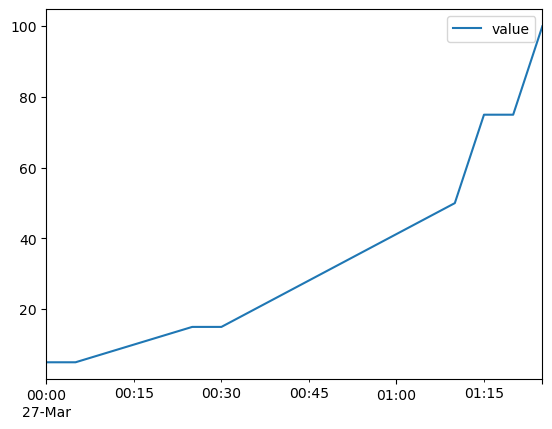

In [ ]:
import pandas as pd

def resample_dataframe(df):
    # Ensure the 'startDate' and 'endDate' columns are in datetime format
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Create a new dataframe with a datetime index at 5-minute intervals
    time_range = pd.date_range(df['startDate'].min(), df['endDate'].max(), freq='5T')
    resampled_df = pd.DataFrame(index=time_range, columns=['value', 'count'])

    # Iterate through the original dataframe and update the resampled dataframe
    for index, row in df.iterrows():
        start_loc = resampled_df.index.get_loc(row['startDate'], method='nearest')
        end_loc = resampled_df.index.get_loc(row['endDate'], method='nearest')
        
        resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'value'] = \
            resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'value'].add(row['value'], fill_value=0)
        resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'count'] = \
            resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'count'].add(1, fill_value=0)

    # Calculate the mean value for overlapping intervals
    resampled_df['value'] = resampled_df['value'] / resampled_df['count']
    resampled_df.drop(columns=['count'], inplace=True)

    # Forward fill the missing values with a limit of 1 interval
    resampled_df['value'] = resampled_df['value'].ffill(limit=1)

    # Interpolate the missing values linearly
    resampled_df['value'] = resampled_df['value'].interpolate(method='linear')

    return resampled_df

# Example usage
data = {
    'startDate': ['2023-03-27 00:00:00', '2023-03-27 00:10:00', '2023-03-27 00:20:00', '2023-03-27 01:10:00', '2023-03-27 01:15:00'],
    'endDate': ['2023-03-27 00:09:00', '2023-03-27 00:19:00', '2023-03-27 00:27:00','2023-03-27 01:20:00','2023-03-27 01:25:00'],
    'value': [5, 10, 15, 50, 100]
}

df = pd.DataFrame(data)
resampled_df = resample_dataframe(df)
print(resampled_df)
resampled_df.plot()

                  date       hr
0  2023-03-27 00:00:00    5.000
1  2023-03-27 00:05:00    5.000
2  2023-03-27 00:10:00   10.000
3  2023-03-27 00:15:00   10.000
4  2023-03-27 00:20:00   15.000
5  2023-03-27 00:25:00   15.000
6  2023-03-27 00:30:00   15.000
7  2023-03-27 00:35:00   19.375
8  2023-03-27 00:40:00   23.750
9  2023-03-27 00:45:00   28.125
10 2023-03-27 00:50:00   32.500
11 2023-03-27 00:55:00   36.875
12 2023-03-27 01:00:00   41.250
13 2023-03-27 01:05:00   45.625
14 2023-03-27 01:10:00   50.000
15 2023-03-27 01:15:00   75.000
16 2023-03-27 01:20:00   75.000
17 2023-03-27 01:25:00  100.000


<Axes: >

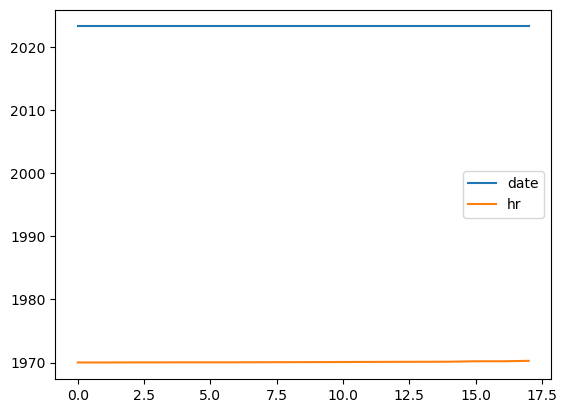

In [ ]:
def resample_dataframe_3(df, name):
    # Ensure the 'startDate' and 'endDate' columns are in datetime format
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Create a new dataframe with a datetime index at 5-minute intervals
    time_range = pd.date_range(df['startDate'].min(), df['endDate'].max(), freq='5T')
    resampled_df = pd.DataFrame(index=time_range, columns=['value', 'count'])

    # Iterate through the original dataframe and update the resampled dataframe
    for index, row in df.iterrows():
        # Create a mask for rows within the start and end dates
        mask = (resampled_df.index >= row['startDate']) & (resampled_df.index <= row['endDate'])

        # Update the 'value' and 'count' columns for rows within the start and end dates
        resampled_df.loc[mask, 'value'] = resampled_df.loc[mask, 'value'].add(row['value'], fill_value=0)
        resampled_df.loc[mask, 'count'] = resampled_df.loc[mask, 'count'].add(1, fill_value=0)

    # Calculate the mean value for overlapping intervals
    resampled_df['value'] = resampled_df['value'] / resampled_df['count']
    resampled_df.drop(columns=['count'], inplace=True)

    # Forward fill the missing values with a limit of 1 interval
    resampled_df['value'] = resampled_df['value'].ffill(limit=1)

    # Interpolate the missing values linearly
    resampled_df['value'] = resampled_df['value'].interpolate(method='linear')

    # Rename the 'value' column to the name of the original time-series
    resampled_df.rename(columns={'value': name}, inplace=True)
    
    # retrun with reset named index 'date'
    return resampled_df.reset_index().rename(columns={'index': 'date'})

resampled_df_3 = resample_dataframe_3(df, "hr")
print(resampled_df_3)
resampled_df_3.plot()

                  date  hr
0  2023-03-27 00:00:00 NaN
1  2023-03-27 00:05:00 NaN
2  2023-03-27 00:10:00 NaN
3  2023-03-27 00:15:00 NaN
4  2023-03-27 00:20:00 NaN
5  2023-03-27 00:25:00 NaN
6  2023-03-27 00:30:00 NaN
7  2023-03-27 00:35:00 NaN
8  2023-03-27 00:40:00 NaN
9  2023-03-27 00:45:00 NaN
10 2023-03-27 00:50:00 NaN
11 2023-03-27 00:55:00 NaN
12 2023-03-27 01:00:00 NaN
13 2023-03-27 01:05:00 NaN
14 2023-03-27 01:10:00 NaN
15 2023-03-27 01:15:00 NaN
16 2023-03-27 01:20:00 NaN
17 2023-03-27 01:25:00 NaN


<Axes: >

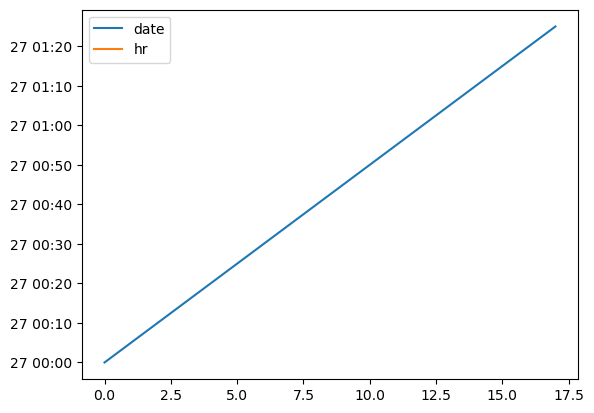

In [ ]:
def resample_dataframe_4(df, name):
    # Ensure the 'startDate' and 'endDate' columns are in datetime format
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Create a new dataframe with a datetime index at 5-minute intervals
    time_range = pd.date_range(df['startDate'].min(), df['endDate'].max(), freq='5T')
    resampled_df = pd.DataFrame(index=time_range, columns=['value', 'count'])

    # Sort the original dataframe by startDate
    df.sort_values(by='startDate', inplace=True)

    # Sort the resampled dataframe by its index
    resampled_df.sort_index(inplace=True)

    # Merge the dataframes using merge_asof
    merged_df = pd.merge_asof(resampled_df.reset_index(), df, left_on='index', right_on='startDate', direction='forward')

    # Fill NaN values with 0 in 'value' column
    merged_df['value_y'].fillna(0, inplace=True)

    # Apply the endDate constraint and update the 'value' and 'count' columns
    merged_df.loc[merged_df['index'] <= merged_df['endDate'], 'value_x'] += merged_df['value_y']
    merged_df.loc[merged_df['index'] <= merged_df['endDate'], 'count'] += 1

    # Drop unnecessary columns and set the index back to the original
    merged_df.drop(columns=['startDate', 'endDate', 'value_y'], inplace=True)
    merged_df.rename(columns={'value_x': 'value'}, inplace=True)
    merged_df.set_index('index', inplace=True)

    resampled_df = merged_df.copy()

    # Calculate the mean value for overlapping intervals
    resampled_df['value'] = resampled_df['value'] / resampled_df['count']
    resampled_df.drop(columns=['count'], inplace=True)

    # Forward fill the missing values with a limit of 1 interval
    resampled_df['value'] = resampled_df['value'].ffill(limit=1)

    # Interpolate the missing values linearly
    resampled_df['value'] = resampled_df['value'].interpolate(method='linear')

    # Rename the 'value' column to the name of the original time-series
    resampled_df.rename(columns={'value': name}, inplace=True)
    
    # retrun with reset named index 'date'
    return resampled_df.reset_index().rename(columns={'index': 'date'})


resampled_df_4 = resample_dataframe_4(df, "hr")
print(resampled_df_4)
resampled_df_4.plot()

                          value
2023-03-27 00:00:00    5.000000
2023-03-27 00:05:00    5.000000
2023-03-27 00:10:00   10.000000
2023-03-27 00:15:00   10.000000
2023-03-27 00:20:00   15.000000
2023-03-27 00:25:00   15.000000
2023-03-27 00:30:00   18.888889
2023-03-27 00:35:00   22.777778
2023-03-27 00:40:00   26.666667
2023-03-27 00:45:00   30.555556
2023-03-27 00:50:00   34.444444
2023-03-27 00:55:00   38.333333
2023-03-27 01:00:00   42.222222
2023-03-27 01:05:00   46.111111
2023-03-27 01:10:00   50.000000
2023-03-27 01:15:00  100.000000
2023-03-27 01:20:00  100.000000
2023-03-27 01:25:00  100.000000


/tmp/ipykernel_2101/1922877608.py:12: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_dates = resampled_df.index.get_loc(row['startDate'], method='nearest')


<Axes: >

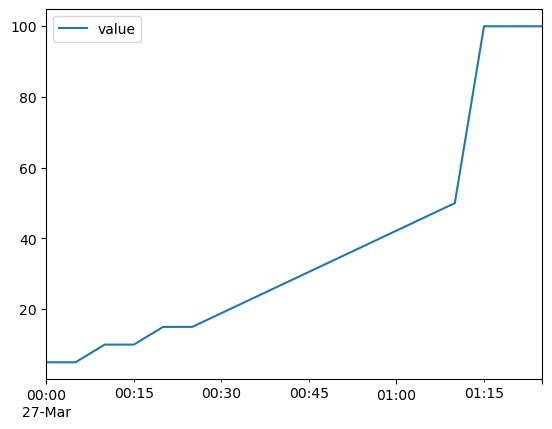

In [ ]:
def resample_dataframe_2(df):
    # Ensure the 'startDate' and 'endDate' columns are in datetime format
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Create a new dataframe with a datetime index at 5-minute intervals
    time_range = pd.date_range(df['startDate'].min(), df['endDate'].max(), freq='5T')
    resampled_df = pd.DataFrame(index=time_range, columns=['value'])

    # Iterate through the original dataframe and update the resampled dataframe
    for index, row in df.iterrows():
        closest_dates = resampled_df.index.get_loc(row['startDate'], method='nearest')
        resampled_df.loc[resampled_df.index[closest_dates], 'value'] = row['value']

    # Forward fill the missing values with a limit of 1 interval
    resampled_df['value'] = resampled_df['value'].ffill(limit=1)

    # Interpolate the missing values linearly
    resampled_df['value'] = resampled_df['value'].interpolate(method='linear')

    return resampled_df

resampled_df_2 = resample_dataframe_2(df)
print(resampled_df_2)
resampled_df_2.plot()

I have a dataframes with the following columns: startDate, endDate, and value. The dates are specific timestamp and a value is an average measurement between those two datestimes. I'd like to create a function to spread the values put across equal time intervals (5 minutes) with the following constraints:
- when resampling the time into new intervals the value for that new intervals should be the closest measured value. This could be closest to either a start or end date. If closest to an endDate that value must be chosen, etc.
- missing values further than 1 interval away should be linearly interpolated at each step between the known values
- Some measurements will overlap and in that case the mean should be chosen for the overlapping internal
- the final output should be timestamps with equal intervals and their values 

This is what I've developed:
def resample_dataframe(df):
    # Ensure the 'startDate' and 'endDate' columns are in datetime format
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Create a new dataframe with a datetime index at 5-minute intervals
    time_range = pd.date_range(df['startDate'].min(), df['endDate'].max(), freq='5T')
    resampled_df = pd.DataFrame(index=time_range, columns=['value', 'count'])

    # Iterate through the original dataframe and update the resampled dataframe
    for index, row in df.iterrows():
        start_loc = resampled_df.index.get_loc(row['startDate'], method='nearest')
        end_loc = resampled_df.index.get_loc(row['endDate'], method='nearest')
        
        resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'value'] = \
            resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'value'].add(row['value'], fill_value=0)
        resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'count'] = \
            resampled_df.loc[resampled_df.index[start_loc:end_loc+1], 'count'].add(1, fill_value=0)

    # Calculate the mean value for overlapping intervals
    resampled_df['value'] = resampled_df['value'] / resampled_df['count']
    resampled_df.drop(columns=['count'], inplace=True)

    # Forward fill the missing values with a limit of 1 interval
    resampled_df['value'] = resampled_df['value'].ffill(limit=1)

    # Interpolate the missing values linearly
    resampled_df['value'] = resampled_df['value'].interpolate(method='linear')

    return resampled_df

However, I noticed while it properly averages overlapping intervals, it is not correct between start date and end dates. It seems to be interpolating even between start and end dates when it should just be using the given value in those intervals. For instance if start and end times on a day are 00:10:00 and 00:19:00 and the value was 5, I'd expect it to be 5 from 00:10:00 to 00:19:00, and in the 5T resampled, 00:20:00 would be also be 5 because its the closest. Interpolation would happen after 00:20:00 (00:25:00) if there was nothing close to 00:25:00.
Please only show changes needed

                            date    hr
0      2020-09-26 00:00:00-04:00  61.0
1      2020-09-26 00:01:00-04:00  61.0
2      2020-09-26 00:02:00-04:00  61.0
3      2020-09-26 00:03:00-04:00  61.0
4      2020-09-26 00:04:00-04:00  61.0
...                          ...   ...
665335 2021-12-31 23:55:00-05:00  74.0
665336 2021-12-31 23:56:00-05:00  74.0
665337 2021-12-31 23:57:00-05:00  74.0
665338 2021-12-31 23:58:00-05:00  74.0
665339 2021-12-31 23:59:00-05:00  74.0

[665340 rows x 2 columns]


<Axes: >

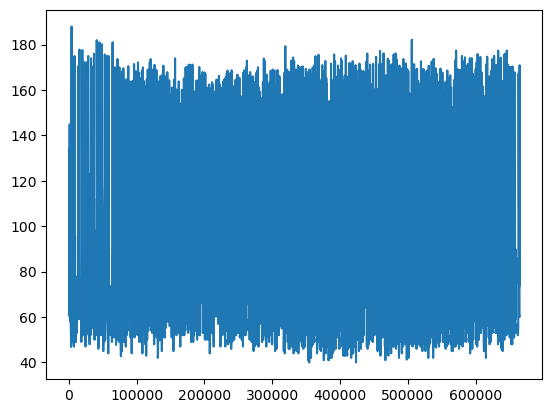

In [ ]:
def resample_dataframe(df, name, start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00', resample_freq = "1T", interpolate = True):
    # Ensure the 'startDate' and 'endDate' columns are in datetime format
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])
    
    # Convert start_date and end_date to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Create a new dataframe with a datetime index at 5-minute intervals
    time_range = pd.date_range(start_date, end_date, freq=resample_freq, tz = 'US/Eastern')
    resampled_df = pd.DataFrame(index=time_range, columns=['value', 'count'])

    # Iterate through the original dataframe and update the resampled dataframe
    for index, row in df.iterrows():
        # Create a mask for rows within the start and end dates
        mask = (resampled_df.index >= row['startDate']) & (resampled_df.index <= row['endDate'])

        # Update the 'value' and 'count' columns for rows within the start and end dates
        resampled_df.loc[mask, 'value'] = resampled_df.loc[mask, 'value'].add(row['value'], fill_value=0)
        resampled_df.loc[mask, 'count'] = resampled_df.loc[mask, 'count'].add(1, fill_value=0)

    # Calculate the mean value for overlapping intervals
    resampled_df['value'] = resampled_df['value'] / resampled_df['count']
    resampled_df.drop(columns=['count'], inplace=True)

    # Forward fill the missing values with a limit of 1 interval
    resampled_df['value'] = resampled_df['value'].ffill(limit=1)

    # Interpolate the missing values linearly
    if interpolate:
        resampled_df['value'] = resampled_df['value'].interpolate(method='linear')
    else:
        resampled_df['value'] = resampled_df['value'].fillna(0)

    # bfill and ffill to fill in the first and last values
    resampled_df['value'] = resampled_df['value'].fillna(method='ffill').fillna(method='bfill')

    # Rename the 'value' column to the name of the original time-series
    resampled_df.rename(columns={'value': name}, inplace=True)

    # retrun with reset named index 'date'
    return resampled_df.reset_index().rename(columns={'index': 'date'})

start_date='2020-09-26 00:00:00'
end_date='2021-12-31 23:59:59'

df_hr = pd.read_csv('../data/xml_export/HeartRate.csv', low_memory=False)
df_hr = df_hr[(df_hr['startDate'] >= start_date) & (df_hr['startDate'] <= end_date)]

hr = resample_dataframe(df_hr, "hr", start_date, end_date)
print(hr)
hr.hr.plot()

In [ ]:
csv_values = [('../data/xml_export/HeartRate.csv', 'hr'),
              ('../data/train_detailed.csv', 'sleep')]

df_sleep = pd.read_csv('../data/train_detailed.csv', low_memory=False)
df_sleep = df_sleep[(df_sleep['startDate'] >= start_date) & (df_sleep['startDate'] <= end_date)]

# Remove rows with value HKCategoryValueSleepAnalysisInBed
df_sleep = df_sleep[df_sleep['value'] != 'HKCategoryValueSleepAnalysisInBed']
df_sleep['value'] = df_sleep['value'].replace({"HKCategoryValueSleepAnalysisInBed": 0.1, "HKCategoryValueSleepAnalysisAsleepUnspecified" : 1.0})
sleep = resample_dataframe(df_sleep, "sleep", start_date, end_date, interpolate=False)

# merge with hr
df = pd.merge(hr, sleep, on='date', how='outer')

print(df.head())


                       date    hr  sleep
0 2020-09-26 00:00:00-04:00  59.0    0.0
1 2020-09-26 00:05:00-04:00  59.0    0.0
2 2020-09-26 00:10:00-04:00  61.0    0.0
3 2020-09-26 00:15:00-04:00  59.0    0.0
4 2020-09-26 00:20:00-04:00  57.0    0.0


In [ ]:
import matplotlib.pyplot as plt

# set date as index
df.set_index('date', inplace=True)

# If sleep > 0.5 then sleep = 1 else sleep = 0
#df['sleep'] = df['sleep'].apply(lambda x: 1 if x > 0.5 else 0)


/tmp/ipykernel_2101/2423360957.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_sample = df['2020-11-01']


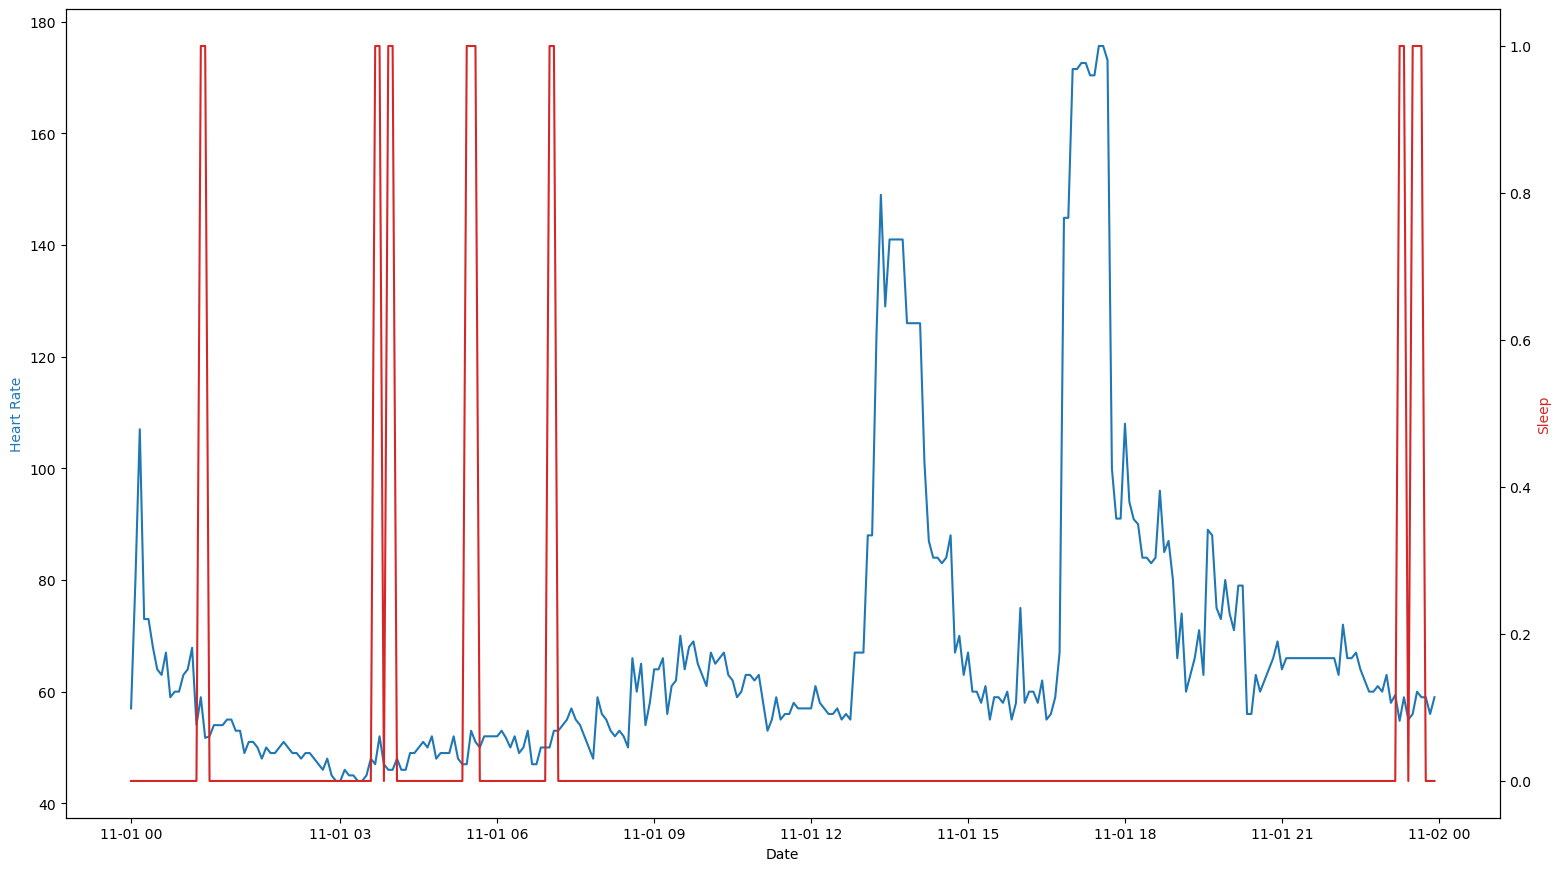

In [ ]:

# set date as index
df.set_index('date', inplace=True)
# Plot with hr and sleep on seperate axis
df_sample = df['2020-11-01']

fig, ax1 = plt.subplots()

# change fig size
fig.set_size_inches(18.5, 10.5)

#ax2 y is 0 to 1
ax2 = ax1.twinx()

# set axis labels   
ax1.set_xlabel('Date')
ax1.set_ylabel('Heart Rate', color='tab:blue')
ax2.set_ylabel('Sleep', color='tab:red')
ax1.plot(df_sample.index, df_sample['hr'], color='tab:blue')
ax2.plot(df_sample.index, df_sample['sleep'], color='tab:red')
plt.show()


In [ ]:
def create_lags(df, n_lags, column_name):
    for i in range(1, n_lags+1):
        df[f"{column_name}_bckwd_{i}"] = df[column_name].shift(i)
        df[f"{column_name}_fwd_{i}"] = df[column_name].shift(-i)
    return df


df2 = create_lags(resampled_df, 12, "hr")

In [ ]:
df["2020-09-26"].hr.tail(20)

/tmp/ipykernel_2101/968691348.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df["2020-09-26"].hr.tail(20)


date
2020-09-26 23:40:00-04:00    59.570388
2020-09-26 23:41:00-04:00    59.567961
2020-09-26 23:42:00-04:00    59.565534
2020-09-26 23:43:00-04:00    59.563107
2020-09-26 23:44:00-04:00    59.560680
2020-09-26 23:45:00-04:00    59.558252
2020-09-26 23:46:00-04:00    59.555825
2020-09-26 23:47:00-04:00    59.553398
2020-09-26 23:48:00-04:00    59.550971
2020-09-26 23:49:00-04:00    59.548544
2020-09-26 23:50:00-04:00    59.546117
2020-09-26 23:51:00-04:00    59.543689
2020-09-26 23:52:00-04:00    59.541262
2020-09-26 23:53:00-04:00    59.538835
2020-09-26 23:54:00-04:00    59.536408
2020-09-26 23:55:00-04:00    59.533981
2020-09-26 23:56:00-04:00    59.531553
2020-09-26 23:57:00-04:00    59.529126
2020-09-26 23:58:00-04:00    59.526699
2020-09-26 23:59:00-04:00    59.524272
Name: hr, dtype: float64

                            date    hr
0      2020-09-26 00:00:00-04:00  59.0
1      2020-09-26 00:05:00-04:00  59.0
2      2020-09-26 00:10:00-04:00  61.0
3      2020-09-26 00:15:00-04:00  59.0
4      2020-09-26 00:20:00-04:00  57.0
...                          ...   ...
133063 2021-12-31 23:35:00-05:00  65.0
133064 2021-12-31 23:40:00-05:00  65.0
133065 2021-12-31 23:45:00-05:00  65.0
133066 2021-12-31 23:50:00-05:00  65.0
133067 2021-12-31 23:55:00-05:00  65.0

[133068 rows x 2 columns]


<Axes: >

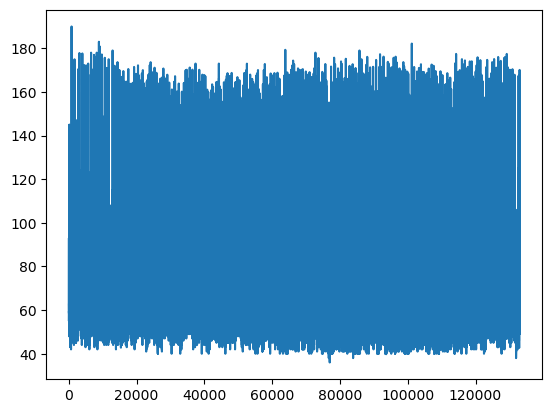

In [ ]:
import numpy as np

def resample_dataframe(df, name, start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00', resample_freq = "5T", interpolate = True):
    # Ensure the 'startDate' and 'endDate' columns are in datetime format
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])
    
    # Convert start_date and end_date to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Create a new dataframe with a datetime index at 5-minute intervals
    time_range = pd.date_range(start_date, end_date, freq=resample_freq, tz = 'US/Eastern')
    resampled_df = pd.DataFrame(index=time_range, columns=[name])

    interval = pd.to_timedelta(resample_freq)

    for t in time_range:
        # Find the index of the closest startDate and endDate in the original dataframe
        closest_start_date_index = (df['startDate'] - t).abs().idxmin()
        closest_end_date_index = (df['endDate'] - t).abs().idxmin()

        # Determine the closest date and corresponding value
        if abs(df.loc[closest_start_date_index, 'startDate'] - t) < abs(df.loc[closest_end_date_index, 'endDate'] - t):
            closest_distance = abs(df.loc[closest_start_date_index, 'startDate'] - t)
            closest_value = df.loc[closest_start_date_index, 'value']
        else:
            closest_distance = abs(df.loc[closest_end_date_index, 'endDate'] - t)
            closest_value = df.loc[closest_end_date_index, 'value']

        # Assign the closest value to the resampled dataframe if it's within the limit
        if closest_distance <= interval:
            resampled_df.loc[t, name] = closest_value
        else:
            resampled_df.loc[t, name] = np.nan
            
    # Interpolate the missing values linearly
    if interpolate:
        resampled_df[name] = resampled_df[name].interpolate(method='linear')
    else:
        resampled_df[name] = resampled_df[name].fillna(0)

    # bfill and ffill to fill in the first and last values
    resampled_df[name] = resampled_df[name].fillna(method='ffill').fillna(method='bfill')

    # Rename the 'value' column to the name of the original time-series
    #resampled_df.rename(columns={'value': name}, inplace=True)

    # retrun with reset named index 'date'
    return resampled_df.reset_index().rename(columns={'index': 'date'})

start_date='2020-09-26 00:00:00'
end_date='2021-12-31 23:59:59'

df_hr = pd.read_csv('../data/xml_export/HeartRate.csv', low_memory=False)
df_hr = df_hr[(df_hr['startDate'] >= start_date) & (df_hr['startDate'] <= end_date)]

hr = resample_dataframe(df_hr, "hr", start_date, end_date)
print(hr)
hr.hr.plot()

In [ ]:
import pytz
def process_sleep_data(df, freq='1min', start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
    #exclude where valud is HKCategoryValueSleepAnalysisInBed
    df = df.drop(df[df['value'] != 'HKCategoryValueSleepAnalysisInBed'].index)
    
    # Parse dates and times
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])
    df['adjusted_startDate'] = df['startDate'] - pd.to_timedelta('12:00:00') # Subtract 12 hours from startDate

    # Group by date and find min startDate and max endDate
    df = df.groupby(df['adjusted_startDate'].dt.date).agg(startDate=('startDate', 'min'),endDate=('endDate', 'max')).reset_index(drop=True)
    df["value"] = 1 
    
    date_range = pd.date_range(start_date, end_date, freq=freq, tz = pytz.FixedOffset(-240))
    expanded_df = pd.DataFrame(date_range, columns=['date'])
    expanded_df['value'] = 0 # Start with 0 and replace with 1s if in interval

    for _, row in df.iterrows():
        mask = (expanded_df['date'] >= row['startDate']) & (expanded_df['date'] <= row['endDate'])
        expanded_df.loc[mask, 'value'] = row['value']
        
    expanded_df = expanded_df.rename(columns={'value': 'sleep'})

    return expanded_df

df_sleep = pd.read_csv('../data/train_detailed.csv', low_memory=False)
df_sleep = process_sleep_data(df_sleep)

print(df_sleep.head(2))
print(df_sleep.date.dt.tz)


                       date  sleep
0 2020-09-26 00:00:00-04:00      0
1 2020-09-26 00:01:00-04:00      0
pytz.FixedOffset(-240)


In [ ]:
def preprocess_feature_data(df, col_name, freq='1min', start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
    df = df[(df['startDate'] >= start_date) & (df['startDate'] <= end_date)]
    
    df = pd.melt(df, id_vars=['value'], value_vars=['startDate', 'endDate'], value_name='date')
    df = df.groupby('date', as_index=False).mean(numeric_only=True)
    df = df.sort_values(by='date')
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.resample(freq).mean()
    
    df = df.interpolate().rolling(2).mean()
    df = df.fillna(method="bfill")
    
    df = df.reset_index()
    df = df.rename(columns={'date': 'date', 'value': col_name})
    
    return df

df_hr = pd.read_csv('../data/xml_export/HeartRate.csv', low_memory=False)
df_hr = preprocess_feature_data(df_hr, "hr", freq='1min')

# Good Features: HR, StepCount, DistanceWalkingRunning,

print(df_hr.head(2))
print(df_hr.date.dt.tz)

                       date    hr
0 2020-09-26 00:01:00-04:00  59.0
1 2020-09-26 00:02:00-04:00  59.0
pytz.FixedOffset(-240)


<bound method NDFrame.sample of                                   hr  sleep
date                                       
2020-09-26 00:01:00-04:00  59.000000      0
2020-09-26 00:02:00-04:00  59.000000      0
2020-09-26 00:03:00-04:00  59.166667      0
2020-09-26 00:04:00-04:00  59.500000      0
2020-09-26 00:05:00-04:00  59.833333      0
...                              ...    ...
2023-03-16 23:57:00-04:00  64.500000      0
2023-03-16 23:58:00-04:00  65.500000      0
2020-09-26 00:00:00-04:00        NaN      0
2023-03-16 23:59:00-04:00        NaN      0
2023-03-17 00:00:00-04:00        NaN      0

[1298881 rows x 2 columns]>


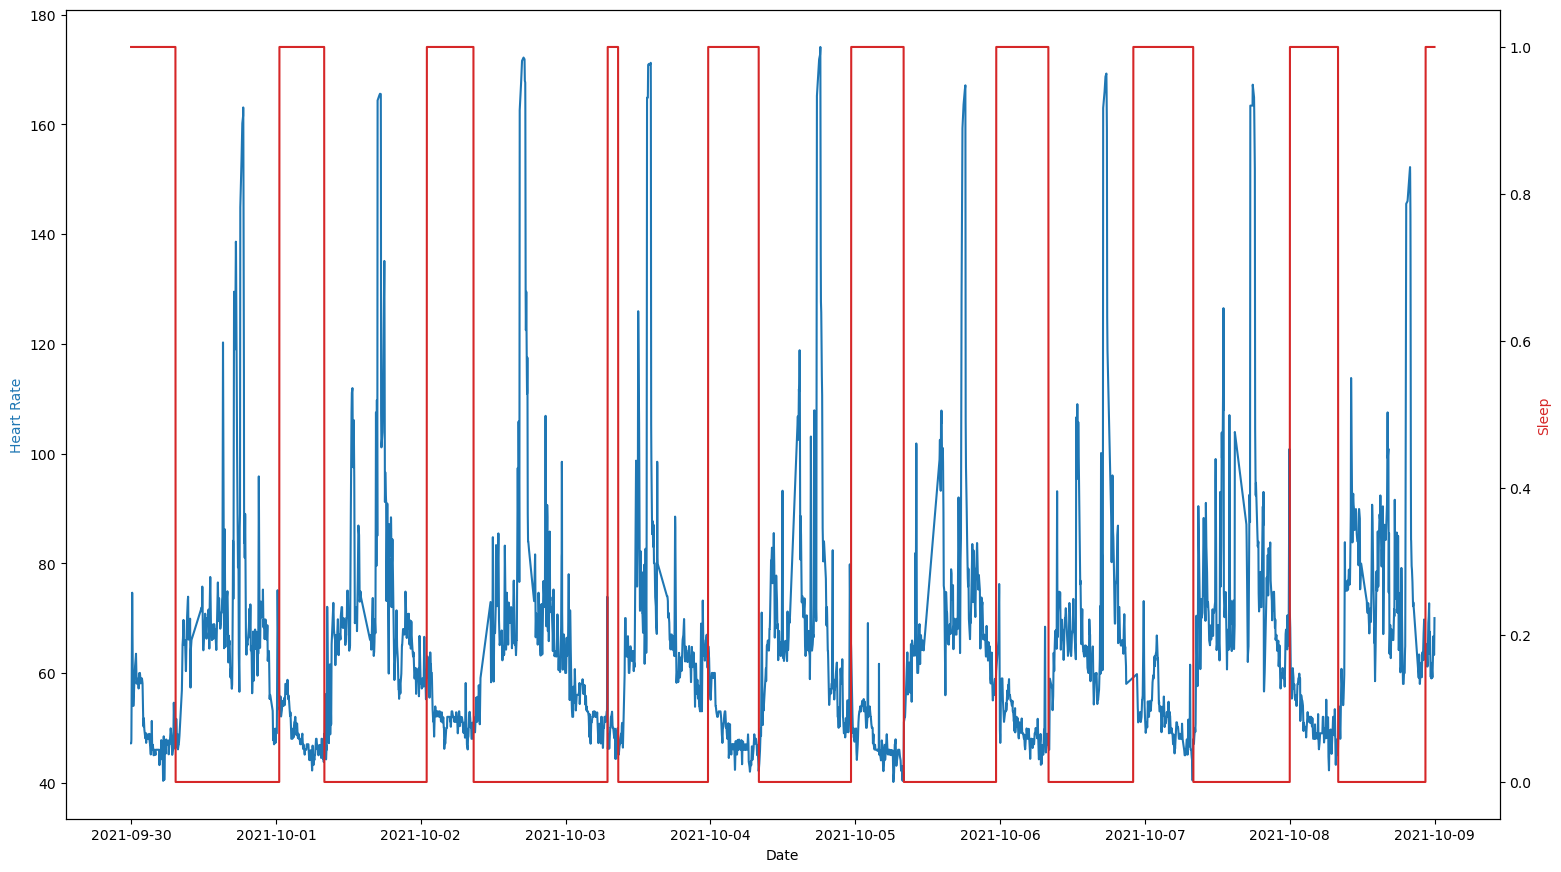

In [ ]:
import matplotlib.pyplot as plt

# merge with hr
df = pd.merge(df_hr, df_sleep, on='date', how='outer')

# set date as index
df.set_index('date', inplace=True)

# Plot with hr and sleep on seperate axis
df_sample = df['2021-09-30':'2021-10-8']
print(df.sample)
fig, ax1 = plt.subplots()

# change fig size
fig.set_size_inches(18.5, 10.5)

#ax2 y is 0 to 1
ax2 = ax1.twinx()

# set axis labels   
ax1.set_xlabel('Date')
ax1.set_ylabel('Heart Rate', color='tab:blue')
ax2.set_ylabel('Sleep', color='tab:red')
ax1.plot(df_sample.index, df_sample['hr'], color='tab:blue')
ax2.plot(df_sample.index, df_sample['sleep'], color='tab:red')
plt.show()


In [ ]:
def create_lags(df, n_lags, column_name):
    bckwd_columns = [df[column_name].shift(i).fillna(method="bfill").fillna(method="ffill").astype('float16') for i in range(1, n_lags+1)]
    fwd_columns = [df[column_name].shift(-i).fillna(method="bfill").fillna(method="ffill").astype('float16') for i in range(1, n_lags+1)]
    bckwd_names = [f"{column_name}_bckwd_{i}" for i in range(1, n_lags+1)]
    fwd_names = [f"{column_name}_fwd_{i}" for i in range(1, n_lags+1)]
    df_lags = pd.concat(bckwd_columns + fwd_columns, axis=1, keys=bckwd_names + fwd_names)
    return pd.concat([df, df_lags], axis=1)


df = create_lags(df.reset_index(), 60, "hr")
df.head()

,date,hr,sleep,hr_bckwd_1,hr_bckwd_2,hr_bckwd_3,hr_bckwd_4,hr_bckwd_5,hr_bckwd_6,hr_bckwd_7,...,hr_fwd_51,hr_fwd_52,hr_fwd_53,hr_fwd_54,hr_fwd_55,hr_fwd_56,hr_fwd_57,hr_fwd_58,hr_fwd_59,hr_fwd_60
0,2020-09-26 00:01:00-04:00,59.000000,0,59.00000,59.00000,59.0,59.0,59.0,59.0,59.0,...,74.00000,69.75000,65.56250,61.34375,57.125,55.00000,55.00000,55.00000,55.00000,55.34375
1,2020-09-26 00:02:00-04:00,59.000000,0,59.00000,59.00000,59.0,59.0,59.0,59.0,59.0,...,69.75000,65.56250,61.34375,57.12500,55.000,55.00000,55.00000,55.00000,55.34375,56.00000
2,2020-09-26 00:03:00-04:00,59.166667,0,59.00000,59.00000,59.0,59.0,59.0,59.0,59.0,...,65.56250,61.34375,57.12500,55.00000,55.000,55.00000,55.00000,55.34375,56.00000,56.65625
3,2020-09-26 00:04:00-04:00,59.500000,0,59.15625,59.00000,59.0,59.0,59.0,59.0,59.0,...,61.34375,57.12500,55.00000,55.00000,55.000,55.00000,55.34375,56.00000,56.65625,57.34375
4,2020-09-26 00:05:00-04:00,59.833333,0,59.50000,59.15625,59.0,59.0,59.0,59.0,59.0,...,57.12500,55.00000,55.00000,55.00000,55.000,55.34375,56.00000,56.65625,57.34375,58.00000


In [ ]:
df.sleep.value_counts(normalize=True)

# Split data at 2021-12-31

df = df.set_index("date")
train = df[:'2021-12-31']
sample = df['2021-12-31':]

train.head()

,hr,sleep,hr_bckwd_1,hr_bckwd_2,hr_bckwd_3,hr_bckwd_4,hr_bckwd_5,hr_bckwd_6,hr_bckwd_7,hr_bckwd_8,...,hr_fwd_51,hr_fwd_52,hr_fwd_53,hr_fwd_54,hr_fwd_55,hr_fwd_56,hr_fwd_57,hr_fwd_58,hr_fwd_59,hr_fwd_60
date,,,,,,,,,,,,,,,,,,,,,
2020-09-26 00:01:00-04:00,59.000000,0,59.00000,59.00000,59.0,59.0,59.0,59.0,59.0,59.0,...,74.00000,69.75000,65.56250,61.34375,57.125,55.00000,55.00000,55.00000,55.00000,55.34375
2020-09-26 00:02:00-04:00,59.000000,0,59.00000,59.00000,59.0,59.0,59.0,59.0,59.0,59.0,...,69.75000,65.56250,61.34375,57.12500,55.000,55.00000,55.00000,55.00000,55.34375,56.00000
2020-09-26 00:03:00-04:00,59.166667,0,59.00000,59.00000,59.0,59.0,59.0,59.0,59.0,59.0,...,65.56250,61.34375,57.12500,55.00000,55.000,55.00000,55.00000,55.34375,56.00000,56.65625
2020-09-26 00:04:00-04:00,59.500000,0,59.15625,59.00000,59.0,59.0,59.0,59.0,59.0,59.0,...,61.34375,57.12500,55.00000,55.00000,55.000,55.00000,55.34375,56.00000,56.65625,57.34375
2020-09-26 00:05:00-04:00,59.833333,0,59.50000,59.15625,59.0,59.0,59.0,59.0,59.0,59.0,...,57.12500,55.00000,55.00000,55.00000,55.000,55.34375,56.00000,56.65625,57.34375,58.00000


In [ ]:
import json
with open("sleep_model_best_params.json", "r") as f:
    sleep_model_best_params = json.load(f)
    
print("Best Parameters for ExtraTrees: ", sleep_model_best_params)

Best Parameters for ExtraTrees:  {'gamma': 0.7483232914389041, 'scaler': 'none', 'max_depth': 6, 'subsample': 0.6298206100536499, 'n_estimators': 830, 'learning_rate': 0.3017020376693815, 'colsample_bytree': 0.7979468286602337, 'min_child_weight': 5}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

X = train.drop(columns=["sleep"])
y = train["sleep"]

xgb_params = {
    "learning_rate": sleep_model_best_params["learning_rate"],
    "max_depth": sleep_model_best_params["max_depth"],
    "n_estimators": sleep_model_best_params["n_estimators"],
    "subsample": sleep_model_best_params["subsample"],
    "colsample_bytree": sleep_model_best_params["colsample_bytree"],
    "gamma": sleep_model_best_params["gamma"],
    "min_child_weight": sleep_model_best_params["min_child_weight"],
    "objective": "binary:logistic",
    "seed": 42
}

scaler = MinMaxScaler()
model = XGBClassifier(**xgb_params, gpu_id=0, tree_method="gpu_hist", random_state=42)

pipeline = Pipeline(steps=[("scaler", scaler),
                           ("model", model)]
                    )

# Set up the cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Perform cross-validation and calculate metrics
cv_scores = cross_val_score(pipeline, X, y, cv=tscv, scoring="roc_auc")
auc = np.mean(cv_scores)

print(f"Mean AUC: {auc:.3f}")

Mean AUC: 0.901


In [ ]:
# Fit on all data
pipeline.fit(X, y)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7979468286602337,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.7483232914389041,
                               gpu_id=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.3017020376693815, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, n_estimators=830,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [ ]:
pipeline.predict_proba(sample.drop(columns=["sleep"]))

array([[9.85445738e-01, 1.45542715e-02],
       [9.40493762e-01, 5.95062338e-02],
       [9.63451743e-01, 3.65482382e-02],
       ...,
       [9.99104798e-01, 8.95182253e-04],
       [9.99834299e-01, 1.65688616e-04],
       [9.99752343e-01, 2.47635093e-04]], dtype=float32)